In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

%matplotlib inline

In [21]:
def fetch_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Adj Close']

def train_test_split(ticker):
    today = datetime.today()
    last_month = today - timedelta(days=365)

    start_date_train = '2015-01-01'
    end_date_train = last_month.strftime('%Y-%m-%d')
    start_date_test = last_month.strftime('%Y-%m-%d')
    end_date_test = today.strftime('%Y-%m-%d')

    stock_data_train = fetch_data(ticker, start_date_train, end_date_train)
    stock_data_test = fetch_data(ticker, start_date_test, end_date_test)

    return stock_data_train, stock_data_test


def calculate_returns(prices):
    returns = prices.pct_change().dropna() * 100
    return returns

def train_hmm_model(data, n_components=3):
    model = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=10000)
    returns_reshaped = data.values.reshape(-1, 1)
    model.fit(returns_reshaped)
    return model

def predict_states(model, data):
    returns_reshaped = data.values.reshape(-1, 1)
    hidden_states = model.predict(returns_reshaped)
    return hidden_states

def plot_results(prices, hidden_states, state_label):
    # Ensure the length of prices and hidden_states match
    if len(prices) > len(hidden_states):
        prices = prices[:len(hidden_states)]
    elif len(hidden_states) > len(prices):
        hidden_states = hidden_states[:len(prices)]

    # Create the plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(prices.index, prices, c=hidden_states, cmap='viridis', marker='o')
    
    # Add the legend with the mapped state labels
    plt.legend(handles=scatter.legend_elements()[0], labels=state_label, title="Market States")
    
    # Set plot title and labels
    plt.title('Hidden States over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

def get_state_labels_from_model(model):
    means = model.means_.flatten()  # Mean of each component (state)

    # Print the means of each state
    print("Means of the hidden states:")
    print(means)

    # Assign labels based on the relative order (min, middle, max)
    state_labels = ['Bull (Stocks Rising)', 'Neutral', 'Bear (Stocks Falling)']

    # Initialize the state mapping dictionary
    state_mapping = {}

    # Get the indices that sort the means array (ascending)
    sorted_indices = np.argsort(means)

    # Map the sorted indices to the state labels (min -> Bear, middle -> Neutral, max -> Bull)
    state_mapping[sorted_indices[0]] = state_labels[2]  # Min -> Bear
    state_mapping[sorted_indices[1]] = state_labels[1]  # Middle -> Neutral
    state_mapping[sorted_indices[2]] = state_labels[0]  # Max -> Bull

    # Print the mapping of components to market states
    print("State Mapping (component -> market state):")
    print(state_mapping)

    # Ensure the state labels correspond to the sorted indices (but keeping original index intact)
    state_actual_labels = [state_mapping[i] for i in range(len(means))]
    print("State Actual Labels:")
    print(state_actual_labels)

    return state_labels

def predict_future_state(model, last_data_point):
    last_return_reshaped = np.array([last_data_point]).reshape(-1, 1)
    future_state = model.predict(last_return_reshaped)
    return future_state[0]



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Means of the hidden states:
[ 0.11109986  0.02293152 -0.48087513]
State Mapping (component -> market state):
{2: 'Bear (Stocks Falling)', 1: 'Neutral', 0: 'Bull (Stocks Rising)'}
State Actual Labels:
['Bull (Stocks Rising)', 'Neutral', 'Bear (Stocks Falling)']


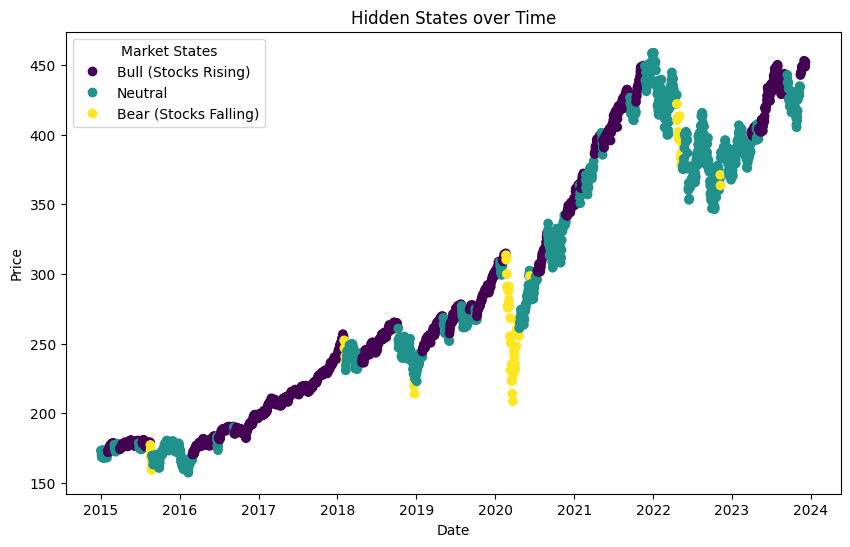

In [22]:
# Define parameters
ticker = 'SPY'
stock_data_train, stock_data_test = train_test_split(ticker)

# Compute returns
returns_train = calculate_returns(stock_data_train)
returns_test = calculate_returns(stock_data_test)

hmm_model_SPY = train_hmm_model(returns_train)

hidden_states_train = predict_states(hmm_model_SPY, returns_train)

state_labels_SPY = get_state_labels_from_model(hmm_model_SPY)

plot_results(stock_data_train, hidden_states_train, state_labels_SPY)



In [23]:

# Predict the future state for training data
last_return_train = returns_train.iloc[-1]
future_state_train = predict_future_state(hmm_model_SPY, last_return_train)

print(f"The predicted market state for the next period based on training data is: {state_labels_SPY[future_state_train]}")

The predicted market state for the next period based on training data is: Neutral


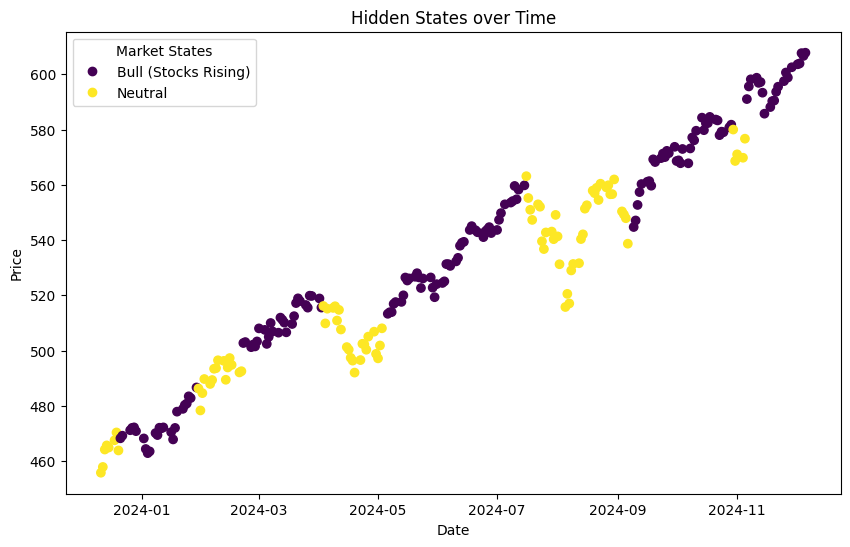

The predicted market state for this next period is: Neutral


In [25]:
# Predict hidden states for testing data
hidden_states_test = predict_states(hmm_model_SPY, returns_test)

# Visualize results for test data
plot_results(stock_data_test, hidden_states_test, state_labels_SPY)

# Predict the future state for test data
last_return_test = returns_test.iloc[-1]
future_state_test = predict_future_state(hmm_model_SPY, last_return_test)

print(f"The predicted market state for this next period is: {state_labels_SPY[future_state_test]}")

In [28]:
state_labels = get_state_labels_from_model(hmm_model_SPY)

print("\nTransition Matrix (%):")
print(" " * 10 + " | ".join([f"{label:^20}" for label in state_labels]))
for i, row in enumerate(hmm_model_SPY.transmat_):
    row_percent = [f"{value * 100:.2f}%" for value in row]
    print(f"{state_labels[i]:<20} | " + " | ".join(row_percent))

# Gaussian HMM does not have emission probabilities in hmmlearn
# Instead, we interpret the means of Gaussian distributions
print("\nState Means (Emission Centers):")
for i, mean in enumerate(hmm_model_SPY.means_):
    print(f"{state_labels[i]}: {mean[0]:.4f}")

Transition Matrix (in %):
['97.48%', '2.27%', '0.25%']
['3.29%', '95.96%', '0.75%']
['0.00%', '11.04%', '88.96%']

Emission Means:
State 0: Mean = [0.11109986]
State 1: Mean = [0.02293152]
State 2: Mean = [-0.48087513]

Emission Covariances:
State 0: Covariance = [[0.26682953]]
State 1: Covariance = [[1.50833259]]
State 2: Covariance = [[12.37840428]]
